## Javad Ranjbar Kermani
## 400209795
## Machine Learning Project

In [42]:
# import libraries
import numpy as np
import pandas as pd 
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math 
import sklearn
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from google.colab import drive 

# DATA CLEANING

In [43]:
def get_data(data_location):
    ############################
    #Define the dataset location
    ############################
    dataset = pd.read_excel(data_location)
    dataset.rename(columns={'u(in)':'velocity','Unnamed: 1':'np concentration','Unnamed: 2':'angle','pipe 1(R1)   (Nu)':'NU_1',
                       'pipe 2(R2)  (Nu)':'NU_2','pipe 3(R3)  (Nu)':'NU_3'}, inplace=True)
    dataset['velocity'] = dataset['velocity'].str.replace(r"\(.*\)","", regex=True)
    dataset['velocity'] = dataset['velocity'].str.strip()
    convert_dict = {'velocity' : float,'np concentration': float,'angle':float}
    dataset = dataset.astype(convert_dict)
    return dataset
drive.mount('/content/drive/')   
dataset = get_data("/content/drive/MyDrive/Colab Notebooks/data.xlsx")

    

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# STATISTIC OVERVIEWS 

In [44]:
dataset.describe(include = 'all')

,velocity,np concentration,angle,NU_1,NU_2,NU_3
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.000419,0.030000,45.000000,6.652500,4.663510,3.964952
std,0.000202,0.022415,33.621939,1.695898,1.165748,1.100830
min,0.000095,0.000000,0.000000,3.350000,2.170000,1.570000
25%,0.000280,0.015000,22.500000,5.490000,3.905000,3.290000
50%,0.000400,0.030000,45.000000,6.595000,4.650000,4.015000
75%,0.000610,0.045000,67.500000,8.270000,5.735000,4.990000
max,0.000760,0.060000,90.000000,9.960000,6.850000,5.860000


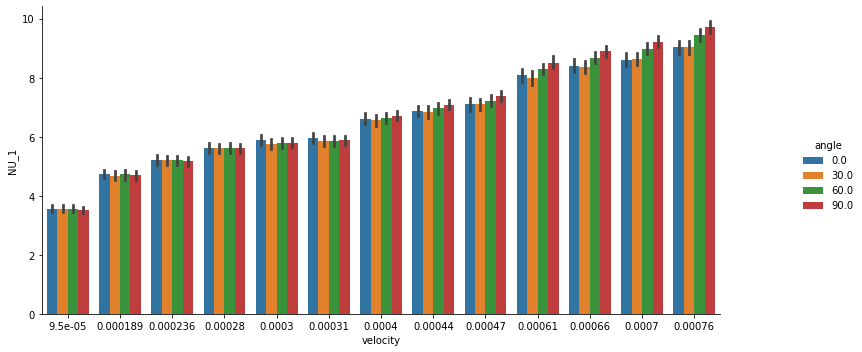

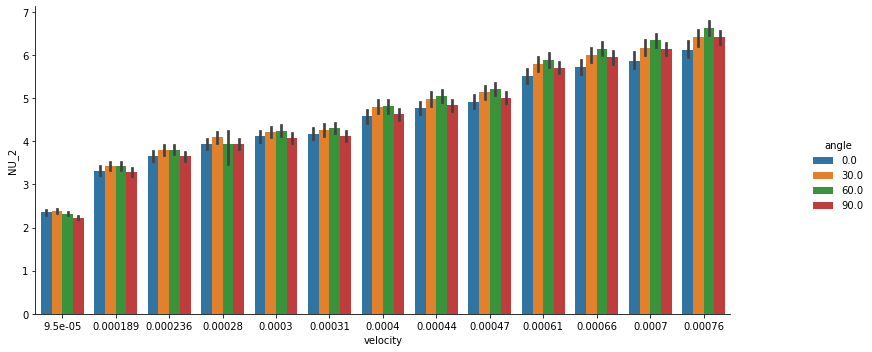

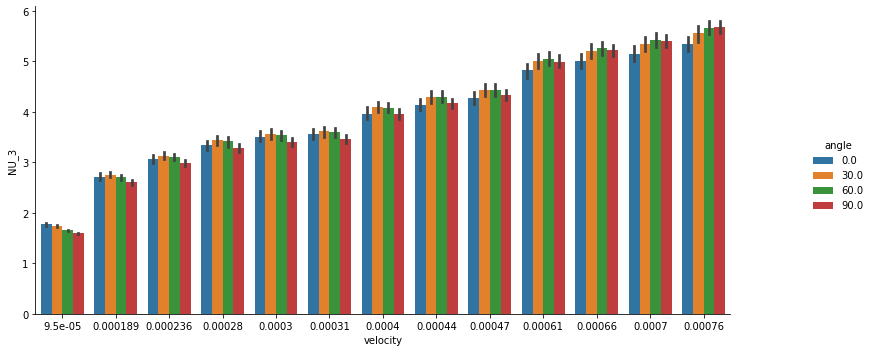

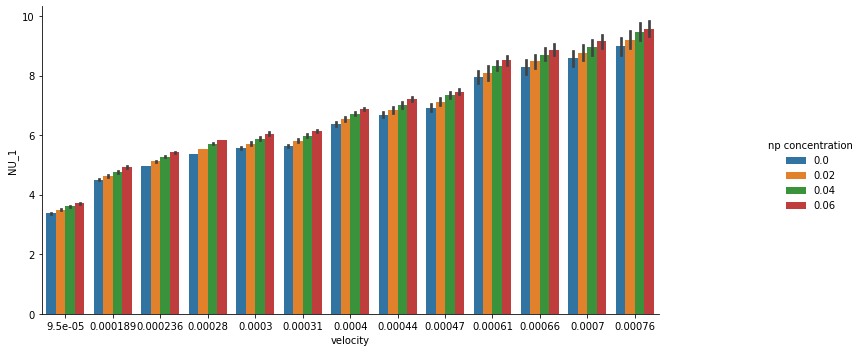

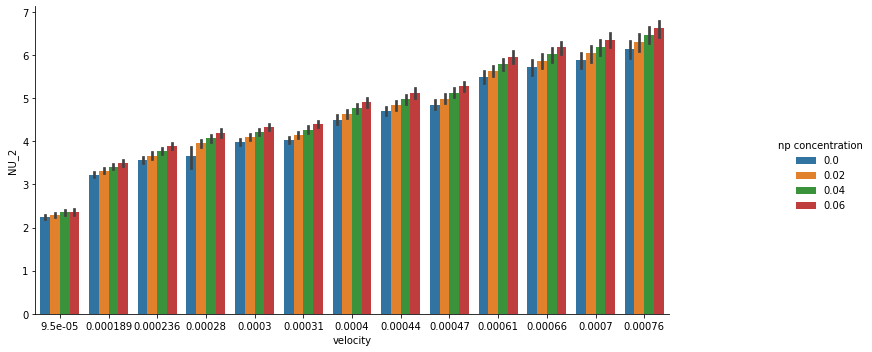

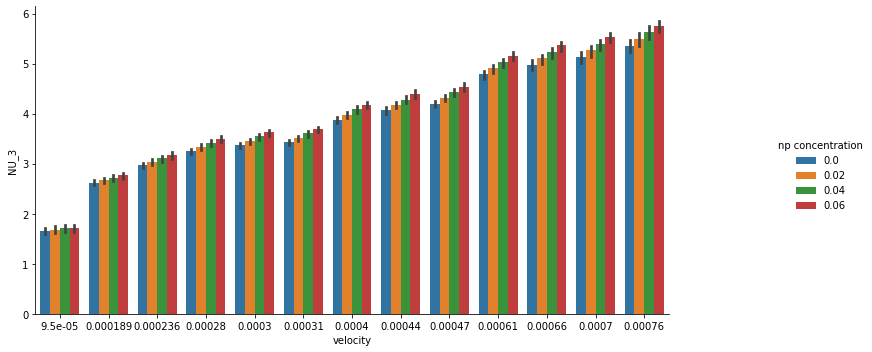

In [45]:
##########################################################
#note that we have three input features and three targets
#to see if we can find any correlation between input features and targets
# these figures are plotted
##########################################################

g_=sns.catplot(x='velocity', y='NU_1',kind='bar',hue='angle' ,data=dataset)
g_.fig.set_size_inches(13,5)
g__=sns.catplot(x='velocity', y='NU_2',kind='bar',hue='angle' ,data=dataset)
g__.fig.set_size_inches(13,5)
g___=sns.catplot(x='velocity', y='NU_3',kind='bar',hue='angle' ,data=dataset)
g___.fig.set_size_inches(13,5)
f_=sns.catplot(x='velocity', y='NU_1',kind='bar',hue='np concentration' ,data=dataset)
f_.fig.set_size_inches(13,5)
f__=sns.catplot(x='velocity', y='NU_2',kind='bar',hue='np concentration' ,data=dataset)
f__.fig.set_size_inches(13,5)
f___=sns.catplot(x='velocity', y='NU_3',kind='bar',hue='np concentration' ,data=dataset)
f___.fig.set_size_inches(13,5)

In [46]:
dataset.corr()
#################################################################
#velocity has a strong corrolation with targets so we expect velocity to be the most important feature
#################################################################

,velocity,np concentration,angle,NU_1,NU_2,NU_3
velocity,1.000000e+00,-3.066843e-17,2.290679e-16,0.985408,0.973212,0.974948
np concentration,-3.066843e-17,1.000000e+00,-4.270089e-18,0.112014,0.124222,0.095836
angle,2.290679e-16,-4.270089e-18,1.000000e+00,0.047429,0.025421,0.010122
NU_1,9.854079e-01,1.120138e-01,4.742858e-02,1.000000,0.990601,0.991768
NU_2,9.732116e-01,1.242219e-01,2.542120e-02,0.990601,1.000000,0.997461
NU_3,9.749481e-01,9.583645e-02,1.012205e-02,0.991768,0.997461,1.000000


In [47]:
#data prepration
#Validation dataset will be used to checkout BEST models generalization
X_train_full, X_valid, Y_train_full, Y_valid = sklearn.model_selection.train_test_split(dataset.iloc[:,[0,1,2]],dataset.iloc[:,[3,4,5]],test_size=0.2,random_state=1)
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_train_full,Y_train_full,test_size=0.3,random_state=1)


In [48]:
def split_target(y):
    return y.iloc[:,0],y.iloc[:,1],y.iloc[:,2]

Nu_1_train_full,Nu_2_train_full,Nu_3_train_full = split_target(y=Y_train_full)
Nu_1_test,Nu_2_test,Nu_3_test = split_target(y=Y_test)
Nu_1_train,Nu_2_train,Nu_3_train = split_target(y=Y_train)
Nu_1_valid,Nu_2_valid,Nu_3_valid = split_target(y=Y_valid)


# Checking ML models without tuning 

In [49]:
def get_models():
    #base models candidates
    models = list()
    models.append(('lr',LinearRegression()))
    models.append(('SVR', SVR()))
    models.append(('RF',RandomForestRegressor()))
    models.append(('neighbour',KNeighborsRegressor()))
    models.append(('tree',DecisionTreeRegressor()))
    return models


def evaluate_models(models,X_train, y_train,X_test,y_test):
    test_scores = list()
    train_scores = list()
    for name,model in models:
        model.fit(X_train, y_train)
        yhat = model.predict(X_test)
        yhat_ = model.predict(X_train)
        r2 = r2_score(y_test, yhat)
        r2_ = r2_score(y_train,yhat_)
        test_scores.append(r2)
        train_scores.append(r2_)
    return test_scores, train_scores
            

    

In [50]:
trial_models = get_models()
evaluate_models(trial_models,X_train,Nu_1_train,X_test,Nu_1_test)

([0.9823330916041146,
  -0.14460531052179193,
  0.9940419196585164,
  0.2948349808795254,
  0.9880421710164533],
 [0.9866201515054784,
  0.008009598748121571,
  0.9993158748592166,
  0.6129182765423269,
  1.0])

In [51]:
evaluate_models(trial_models,X_train,Nu_2_train,X_test,Nu_2_test)

([0.9712044272569373,
  -0.07672661415187854,
  0.9879993482700291,
  0.32296637986581256,
  0.9780985035180783],
 [0.9589860013634115,
  -0.007221363010525339,
  0.9982865173191198,
  0.5964609916682766,
  1.0])

In [52]:
evaluate_models(trial_models,X_train,Nu_3_train,X_test,Nu_3_test)

([0.9648394144167374,
  -0.1056791301538691,
  0.9937810334284963,
  0.3024138203450579,
  0.9916127044673969],
 [0.9564702454021021,
  -0.008199548558550429,
  0.9994060610207915,
  0.5874205450926512,
  1.0])

SVR showed very poor performance and it may be the result of not tuning the model
On the other hand Decision tree showed a good potential for predicting the target but these results are not
reliable becuase of lack of data in test data set (maybe it is overfitted)
Random forest performed well but its performance should also be checked on validation data set.
From above models SVR and Random forest are selected for tuning to see how selecting hyper parameters will effect them


# Tuning random forest

In [53]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [1, 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



In [54]:
# Use the random grid to search for best hyperparameters
#Random forest is used to predict multiple outputs at once 
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 25, cv = 4, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, Y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [55]:
#checking out random forest on test data set and validation dataset
r2_rf_nu1 = [r2_score(Nu_1_train,rf_random.predict(X_train)[:,0]),r2_score(Nu_1_test,rf_random.predict(X_test)[:,0]),r2_score(Nu_1_valid,rf_random.predict(X_valid)[:,0])]
r2_rf_nu2 = [r2_score(Nu_2_train,rf_random.predict(X_train)[:,1]),r2_score(Nu_2_test,rf_random.predict(X_test)[:,1]),r2_score(Nu_2_valid,rf_random.predict(X_valid)[:,1])]
r2_rf_nu3 = [r2_score(Nu_3_train,rf_random.predict(X_train)[:,2]),r2_score(Nu_3_test,rf_random.predict(X_test)[:,2]),r2_score(Nu_3_valid,rf_random.predict(X_valid)[:,2])]

In [56]:
DataFrame(data=[r2_rf_nu1,r2_rf_nu2,r2_rf_nu3],index=['Nu_1','Nu_2','Nu_3'],columns=['train','test','validation'])

,train,test,validation
Nu_1,0.999275,0.992873,0.992108
Nu_2,0.998249,0.987795,0.984726
Nu_3,0.999199,0.991878,0.990790


In [57]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 20,
 'bootstrap': True}

In [58]:
#fitting random forest on whole traing dataset and checking out its performance with same parameters
rf__ = RandomForestRegressor(n_estimators= 1400,min_samples_split=2,min_samples_leaf=1,max_depth=20,bootstrap= True)
rf__.fit(X_train_full,Y_train_full)


RandomForestRegressor(max_depth=20, n_estimators=1400)

In [59]:
r2_score(Nu_1_valid,rf__.predict(X_valid)[:,0]),r2_score(Nu_2_valid,rf__.predict(X_valid)[:,1]),r2_score(Nu_3_valid,rf__.predict(X_valid)[:,2])

(0.9958435898085016, 0.9906267224732046, 0.9947202922413175)

In [60]:
rf__.feature_importances_

array([0.98193549, 0.01150056, 0.00656395])

velocity is the most important features 

### SVR

This model performed very bad over the dataset with negative R2 which means it predicts worse than mean of the data to
change things.   

In [61]:
from sklearn.multioutput import RegressorChain
#for this model hyperparameters are tuned manually with the goal of increasing r_2 for training dataset
#first step
SVR_Model = SVR()
wrapper = MultiOutputRegressor(SVR_Model)
wrapper.fit(X_train, Y_train)
r2_score(Nu_1_train,wrapper.predict(X_train)[:,0]),r2_score(Nu_2_train,wrapper.predict(X_train)[:,1]),r2_score(Nu_3_train,wrapper.predict(X_train)[:,2])


(0.008009598748121571, -0.007221363010525339, -0.008199548558550429)

In [62]:
#to see the difference first step and second step are displayed
#last step

SVR_Model = SVR(kernel="rbf",tol=0.01,epsilon=1,C=10000000, gamma=1)
wrapper = MultiOutputRegressor(SVR_Model)
wrapper.fit(X_train, Y_train)
r2_score(Nu_1_train,wrapper.predict(X_train)[:,0]),r2_score(Nu_2_train,wrapper.predict(X_train)[:,1]),r2_score(Nu_3_train,wrapper.predict(X_train)[:,2])


(0.9002242417246449, 0.7658286289306375, 0.7353941585693795)

In [63]:
#checking out random forest on test data set and validation dataset
r2_svr_nu1 = [r2_score(Nu_1_train,wrapper.predict(X_train)[:,0]),r2_score(Nu_1_test,wrapper.predict(X_test)[:,0]),r2_score(Nu_1_valid,wrapper.predict(X_valid)[:,0])]
r2_svr_nu2 = [r2_score(Nu_2_train,wrapper.predict(X_train)[:,1]),r2_score(Nu_2_test,wrapper.predict(X_test)[:,1]),r2_score(Nu_2_valid,wrapper.predict(X_valid)[:,1])]
r2_svr_nu3 = [r2_score(Nu_3_train,wrapper.predict(X_train)[:,2]),r2_score(Nu_3_test,wrapper.predict(X_test)[:,2]),r2_score(Nu_3_valid,wrapper.predict(X_valid)[:,2])]

In [64]:
DataFrame(data=[r2_svr_nu1,r2_svr_nu2,r2_svr_nu3],index=['Nu_1','Nu_2','Nu_3'],columns=['train','test','validation'])

,train,test,validation
Nu_1,0.900224,0.900390,0.896510
Nu_2,0.765829,0.784098,0.726348
Nu_3,0.735394,0.742525,0.691762


Results are much better but not as good as random forest

# Linear Regression

Text(0.5, 1.0, 'Residual Plots')

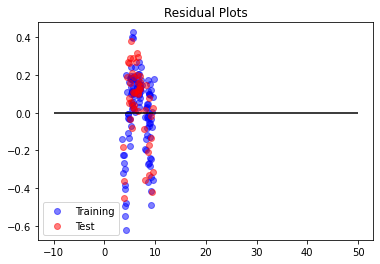

In [65]:
# Scatter plot the training data
linear_model = LinearRegression().fit(X_train,Nu_1_train)
pred_train1 = linear_model.predict(X_train)
pred_test1 = linear_model.predict(X_test)
train = plt.scatter(x=pred_train1,y=(Nu_1_train-pred_train1),c='b',alpha=0.5)

# Scatter plot the testing data
test = plt.scatter(pred_test1,(Nu_1_test-pred_test1),c='r',alpha=0.5)

# Plot a horizontal axis line at 0
plt.hlines(y=0,xmin=-10,xmax=50)

#Labels
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plots')

As showed above the linear model doesnt show unlinear behaviour of the data very well
so I decided to combine the linear model with the KNNregressor which showed poor performance 

# Stacking

In [66]:
stacked_model = MultiOutputRegressor(StackingRegressor(estimators=[('knr', KNeighborsRegressor()),('lr',LinearRegression())],final_estimator=LinearRegression()))
stacked_model.fit(X_train,Y_train)


MultiOutputRegressor(estimator=StackingRegressor(estimators=[('knr',
                                                              KNeighborsRegressor()),
                                                             ('lr',
                                                              LinearRegression())],
                                                 final_estimator=LinearRegression()))

In [67]:
#checking out random forest on test data set and validation dataset
r2_stacked_nu1 = [r2_score(Nu_1_train,stacked_model.predict(X_train)[:,0]),r2_score(Nu_1_test,stacked_model.predict(X_test)[:,0]),r2_score(Nu_1_valid,stacked_model.predict(X_valid)[:,0])]
r2_stacked_nu2 = [r2_score(Nu_2_train,stacked_model.predict(X_train)[:,1]),r2_score(Nu_2_test,stacked_model.predict(X_test)[:,1]),r2_score(Nu_2_valid,stacked_model.predict(X_valid)[:,1])]
r2_stacked_nu3 = [r2_score(Nu_3_train,stacked_model.predict(X_train)[:,2]),r2_score(Nu_3_test,stacked_model.predict(X_test)[:,2]),r2_score(Nu_3_valid,stacked_model.predict(X_valid)[:,2])]


In [68]:
DataFrame(data=[r2_stacked_nu1,r2_stacked_nu2,r2_stacked_nu3],index=['Nu_1','Nu_2','Nu_3'],columns=['train','test','validation'])

,train,test,validation
Nu_1,0.986136,0.981486,0.981742
Nu_2,0.958993,0.971678,0.965972
Nu_3,0.955558,0.966030,0.962668


# Deep_learning

In [69]:
import torch

In [70]:
drive.mount('/content/drive/')   
dataset = get_data("/content/drive/MyDrive/Colab Notebooks/data.xlsx")


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [71]:
dataset.iloc[:,3]= (dataset.iloc[:,3]-dataset.iloc[:,3].min())/(dataset.iloc[:,3].max()-dataset.iloc[:,3].min())
dataset.iloc[:,4]= (dataset.iloc[:,4]-dataset.iloc[:,4].min())/(dataset.iloc[:,4].max()-dataset.iloc[:,4].min())
dataset.iloc[:,5]= (dataset.iloc[:,5]-dataset.iloc[:,5].min())/(dataset.iloc[:,5].max()-dataset.iloc[:,5].min())

In [72]:
dataset.iloc[:,0]= dataset.iloc[:,0]*100000

In [73]:
X_train_full, X_valid, Y_train_full, Y_valid = sklearn.model_selection.train_test_split(dataset.iloc[:,[0,1,2]],dataset.iloc[:,[3,4,5]],test_size=0.25,random_state=1)


In [74]:
Y_train_full

,NU_1,NU_2,NU_3
67,0.270802,0.335470,0.354312
14,0.198185,0.235043,0.261072
164,0.568835,0.564103,0.608392
179,0.824508,0.790598,0.836830
19,0.478064,0.502137,0.545455
...,...,...,...
203,0.639939,0.645299,0.673660
137,0.559758,0.628205,0.648019
72,0.503782,0.585470,0.622378
140,0.819970,0.865385,0.874126


In [75]:
inputs = torch.tensor(X_train_full.values, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
targets = torch.tensor(Y_train_full.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(Y_valid.values, dtype=torch.float32)

data = list(zip(inputs, targets))


In [76]:
from torch.utils.data import TensorDataset, DataLoader
dataloader = DataLoader(data, batch_size=6, shuffle=True)

In [77]:
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self):
        torch.manual_seed(0)
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(3, 30, bias=True)
        nn.init.normal_(self.layer1.weight, mean=0, std=0.01)
        self.layer1.bias.data.fill_(0)
        
        self.layer2 = nn.Linear(30, 3, bias=True)
        nn.init.normal_(self.layer2.weight, mean=0, std=0.01)
        self.layer2.bias.data.fill_(0)


        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)
        self.batchnorm = nn.BatchNorm1d(30)
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.batchnorm(x)
        x = self.sigmoid(x)
        x = self.dropout(x)
        x = self.layer2(x)      
       
        return x

In [78]:
model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [79]:
for epoch in range(100):    
    for input_batch, target_batch in dataloader:
        # Forward pass
        output = model(input_batch)
        loss = criterion(output, target_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [80]:
s= model(X_valid_tensor)
s__ = model(inputs)

In [81]:
#checking out neural network on dataset
r2_NN_nu1 = [r2_score(y_valid_tensor[:,0].detach().numpy(),s[:,0].detach().numpy()),r2_score(targets[:,0].detach().numpy(),s__[:,0].detach().numpy())]
r2_NN_nu2 = [r2_score(y_valid_tensor[:,1].detach().numpy(),s[:,1].detach().numpy()),r2_score(targets[:,1].detach().numpy(),s__[:,1].detach().numpy())]
r2_NN_nu3 = [r2_score(y_valid_tensor[:,2].detach().numpy(),s[:,2].detach().numpy()),r2_score(targets[:,2].detach().numpy(),s__[:,2].detach().numpy())]


In [82]:
DataFrame(data=[r2_NN_nu1,r2_NN_nu2,r2_NN_nu3],index=['Nu_1','Nu_2','Nu_3'],columns=['test','train'])

,test,train
Nu_1,0.923442,0.884246
Nu_2,0.902374,0.865272
Nu_3,0.915240,0.865347
